# 🎯 **Building a Recommendation System with Neural Collaborative Filtering (NCF) and Active Learning**

## 📚 **Introduction**

In this notebook, we explore an innovative approach to building a recommendation system that combines the power of **Neural Collaborative Filtering (NCF)** and **Active Learning**. Our goal is to deliver highly personalized recommendations by leveraging the strengths of deep learning and iterative feedback mechanisms.

### 💡 **Why Neural Collaborative Filtering (NCF)?**
Collaborative Filtering (CF) is a cornerstone of modern recommendation systems, enabling the prediction of user preferences based on historical interaction data. However, traditional matrix factorization methods often fail to capture non-linear patterns in user-item interactions. 

This is where **NCF** excels:
- **Deep Non-linear Modeling**: NCF utilizes deep neural networks to learn complex relationships between users and items.
- **Flexible Representation**: It goes beyond simple dot-product similarity, allowing richer interaction modeling.
- **Scalable and Generalizable**: NCF can efficiently handle large-scale datasets and adapt to various recommendation domains.

### 🔄 **What is Active Learning?**
In scenarios where labeled data is limited, **Active Learning** plays a critical role in improving model performance:
- **Focus on Uncertainty**: By identifying the data points where the model is most uncertain, Active Learning prioritizes which interactions to label next.
- **Efficient Training**: It reduces the need for labeling large datasets by iteratively retraining on the most informative samples.
- **Enhanced Recommendations**: By continuously incorporating new feedback, the system adapts to changing user preferences.

### 🛠 **Our Approach**
1. **Model Architecture**:
   - We leverage a **Neural Collaborative Filtering (NCF)** architecture with embedding layers for users and items.
   - Advanced interaction modeling techniques such as **element-wise multiplication** and **absolute difference** enrich user-item representations.
   - Fully connected layers with dropout and regularization enhance generalization.

2. **Active Learning Loop**:
   - Predict scores for unlabeled user-item pairs.
   - Calculate **uncertainty scores** based on model predictions (e.g., proximity to decision boundaries).
   - Select the most uncertain interactions for labeling and retrain the model iteratively.

3. **Data Pipeline**:
   - Preprocessed interaction data is used to construct a sparse interaction matrix.
   - New interactions from users are dynamically integrated, enabling real-time updates.

4. **Evaluation**:
   - Metrics like **AUC**, **Precision**, and **Recall** evaluate model performance.
   - Active learning's impact is assessed by observing improvements over successive iterations.

### 🌟 **Key Features**
- **Dynamic Retraining**: Our system updates the recommendation model in response to new user interactions, ensuring relevance and accuracy.
- **Scalable and Efficient**: Leveraging NCF's scalability and Active Learning's efficiency, we achieve robust performance with minimal computational overhead.
- **User-Centric**: By prioritizing user feedback, the system evolves alongside changing preferences, offering a seamless recommendation experience.

---

This combination of Neural Collaborative Filtering and Active Learning represents a significant step forward in building smarter, adaptive, and user-focused recommendation systems. Let's dive into the details and uncover the full potential of this approach! 🚀


In [2]:
import os
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 🛠 **CiteULike Data Processor**

## 📜 **Overview**

The `CiteULikeDataProcessor` class provides a robust and structured framework for processing the CiteULike dataset. This dataset contains user interactions, articles, tags, citations, and metadata, making it an excellent source for building personalized recommendation systems. The class is designed to clean, preprocess, and transform raw data into a format suitable for machine learning and recommendation tasks.

---

## 🚀 **Key Features**

1. **Dynamic Data Loading**:
   - Automatically loads and parses multiple dataset components, including:
     - **Citations**: Articles and the articles they cite.
     - **Item Tags**: Tags assigned to articles.
     - **Tags**: The complete list of tags in the dataset.
     - **Users**: Implicit feedback data (interactions between users and articles).
     - **Raw Data**: Titles and abstracts of articles.

2. **Preprocessing Pipelines**:
   - Encodes users and articles using **Label Encoding**.
   - Builds a **sparse interaction matrix** representing user-article interactions.
   - Extracts **text features** from article titles and abstracts using **TF-IDF Vectorization**.
   - Generates **tag features** using the tags associated with articles.

3. **Feature Engineering**:
   - Combines textual and tag features into a single feature matrix for efficient modeling.
   - Uses **scipy.sparse** to handle high-dimensional data efficiently.

4. **Dataset Analysis**:
   - Provides comprehensive statistics, including:
     - Number of users, articles, and tags.
     - Average interactions per user and article.
     - Top 10 most frequent tags in the dataset.

---

## 📂 **Dataset Components**

- **`citations.dat`**: Relationships between articles and their citations.
- **`item-tag.dat`**: Tags linked to each article.
- **`tags.dat`**: The complete list of available tags.
- **`users.dat`**: User-article interaction data, where each user has interacted with a set of articles.
- **`raw-data.csv`**: Metadata for articles, including titles and abstracts.

---

## 🔍 **Core Methods**

1. **`load_citations`**:
   - Reads citation data and builds a dictionary where keys are articles and values are the articles they cite.

2. **`load_item_tags`**:
   - Maps each article to its associated tags.

3. **`load_users`**:
   - Builds a DataFrame representing the interaction matrix, where rows correspond to users and columns to articles.

4. **`process_data`**:
   - Encodes users and articles.
   - Constructs the interaction matrix.
   - Computes TF-IDF features for tags and textual data.

5. **`analyze_dataset`**:
   - Outputs key statistics about the dataset, such as the number of users, articles, and tags, along with interaction distributions and tag frequencies.

---

## 🌟 **Use Case**
The `CiteULikeDataProcessor` serves as a foundational step in recommendation system workflows. It ensures raw data is transformed into a structured, high-quality format, enabling the application of advanced algorithms such as **Neural Collaborative Filtering (NCF)** or **Content-Based Filtering**.

---


In [3]:
import os
import pandas as pd
import numpy as np
import scipy.sparse
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

class CiteULikeDataProcessor:
    def __init__(self, 
                 base_path='/kaggle/input/dataset',
                 citations_path='citations.dat',
                 item_tag_path='item-tag.dat', 
                 tags_path='tags.dat',
                 users_path='users.dat',
                 raw_data_path='raw-data.csv'):
        
        # Chemins des fichiers
        self.base_path = base_path
        self.citations_path = os.path.join(base_path, citations_path)
        self.item_tag_path = os.path.join(base_path, item_tag_path)
        self.tags_path = os.path.join(base_path, tags_path)
        self.users_path = os.path.join(base_path, users_path)
        self.raw_data_path = os.path.join(base_path, raw_data_path)
        
        # Chargement des données
        self.citations = self.load_citations()
        self.item_tags = self.load_item_tags()
        self.tags = self.load_tags()
        self.users_data = self.load_users()
        self.raw_data = pd.read_csv(self.raw_data_path, encoding='latin1')
        
        # Prétraitement
        self.process_data()
    
    def load_citations(self):
        citations = {}
        with open(self.citations_path, 'r', encoding='latin1') as f:
            for line in f:
                try:
                    parts = list(map(int, line.strip().split()))
                    node_id = parts[0]
                    cited_articles = parts[1:]
                    citations[node_id] = cited_articles
                except ValueError:
                    print(f"Skipping malformed line in citations: {line.strip()}")
        return citations
    
    def load_item_tags(self):
        item_tags = {}
        with open(self.item_tag_path, 'r', encoding='latin1') as f:
            for line in f:
                try:
                    parts = list(map(int, line.strip().split()))
                    num_tags = parts[0]
                    tag_ids = parts[1:]
                    item_tags[len(item_tags)] = tag_ids
                except ValueError:
                    print(f"Skipping malformed line in item tags: {line.strip()}")
        return item_tags
    
    def load_tags(self):
        with open(self.tags_path, 'r', encoding='latin1') as f:
            return [line.strip() for line in f]
    
    def load_users(self):
        try:
            with open(self.users_path, 'r', encoding='latin1') as f:
                data = []
                for line in f:
                    # Convert space-delimited integers into a list
                    data.append(list(map(int, line.strip().split())))
                
                # Determine the maximum item ID (columns in interaction matrix)
                max_item_id = max(max(row) for row in data)
                
                # Initialize a DataFrame with zero interactions
                users_data = pd.DataFrame(0, index=range(len(data)), columns=range(max_item_id + 1))
                
                # Populate the DataFrame
                for user_id, items in enumerate(data):
                    for item_id in items:
                        users_data.loc[user_id, item_id] = 1  # Mark interaction as 1
                
                return users_data
        except Exception as e:
            print(f"Error loading users data: {e}")
            return pd.DataFrame()



    
    def process_data(self):
        # Encodage des utilisateurs et articles
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        
        # Création de la matrice d'interactions
        try:
            self.interaction_matrix = csr_matrix(
                self.users_data.values, 
                dtype=np.float32
            )
        except ValueError as e:
            print(f"Error creating interaction matrix: {e}")
            self.interaction_matrix = csr_matrix((0, 0))
        
        # Vectorisation des tags
        self.tag_vectorizer = TfidfVectorizer()
        self.tag_features = self.create_tag_features()
        
        # Création des features textuelles
        self.text_vectorizer = TfidfVectorizer(
            max_features=1000, 
            stop_words='english'
        )
        self.text_features = self.create_text_features()
    
    def create_tag_features(self):
        tag_texts = []
        for item_id, tag_ids in self.item_tags.items():
            try:
                item_tags = [self.tags[tag_id] for tag_id in tag_ids]
                tag_texts.append(' '.join(item_tags))
            except IndexError:
                print(f"Skipping tag with invalid index: {tag_ids}")
        
        return self.tag_vectorizer.fit_transform(tag_texts)
    
    def create_text_features(self):
        try:
            if 'abstract' in self.raw_data.columns:
                text_data = self.raw_data['title'] + ' ' + self.raw_data['abstract']
            else:
                text_data = self.raw_data['title']
            return self.text_vectorizer.fit_transform(text_data)
        except KeyError as e:
            print(f"Missing columns in raw data: {e}")
            return csr_matrix((0, 0))

    
    def get_recommendation_features(self):
        combined_features = scipy.sparse.hstack([
            self.tag_features, 
            self.text_features
        ])
        
        return {
            'interaction_matrix': self.interaction_matrix,
            'combined_features': combined_features,
            'num_users': self.interaction_matrix.shape[0],
            'num_items': self.interaction_matrix.shape[1]
        }
    
    def analyze_dataset(self):
        print("Statistiques du dataset CiteULike:")
        print(f"Nombre d'utilisateurs: {self.interaction_matrix.shape[0]}")
        print(f"Nombre d'articles: {self.interaction_matrix.shape[1]}")
        print(f"Nombre total de tags: {len(self.tags)}")
        print(f"Nombre de citations: {sum(len(cites) for cites in self.citations.values())}")
        
        interactions_per_user = np.array(self.interaction_matrix.sum(axis=1)).flatten()
        interactions_per_item = np.array(self.interaction_matrix.sum(axis=0)).flatten()
        
        print("\nDistribution des interactions:")
        print(f"Interactions moyennes par utilisateur: {interactions_per_user.mean():.2f}")
        print(f"Interactions moyennes par article: {interactions_per_item.mean():.2f}")
        
        tag_counts = {}
        for tags in self.item_tags.values():
            for tag in tags:
                tag_counts[tag] = tag_counts.get(tag, 0) + 1
        
        top_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:10]
        print("\nTop 10 Tags:")
        for tag_id, count in top_tags:
            print(f"{self.tags[tag_id]}: {count}")


# 🚀 Initializing and Analyzing the CiteULike Dataset

This code demonstrates how to initialize the `CiteULikeDataProcessor`, build the interaction matrix, and analyze the dataset for insights into user-article interactions.

- **Initialization**: Loads dataset files like user interactions, tags, and raw metadata.
- **Interaction Matrix**: Represents user-article interactions in a sparse format for efficiency.
- **Dataset Analysis**: Provides statistics such as the number of users, articles, interactions, and the top 10 most frequent tags.

In [4]:
processor = CiteULikeDataProcessor(
    base_path='/kaggle/input/article/dataset',
    citations_path='citations.dat',
    item_tag_path='item-tag.dat',
    tags_path='tags.dat',
    users_path='users.dat',
    raw_data_path='raw-data.csv'
)

In [5]:
processor.interaction_matrix = csr_matrix(processor.users_data.values, dtype=np.float32)

In [6]:
processor.analyze_dataset()

Statistiques du dataset CiteULike:
Nombre d'utilisateurs: 5551
Nombre d'articles: 16980
Nombre total de tags: 46391
Nombre de citations: 4119

Distribution des interactions:
Interactions moyennes par utilisateur: 37.92
Interactions moyennes par article: 12.40

Top 10 Tags:
review: 1735
bioinformatics: 1522
network: 1391
evolution: 1373
networks: 1200
software: 1015
genomics: 993
genome: 805
statistics: 755
analysis: 740


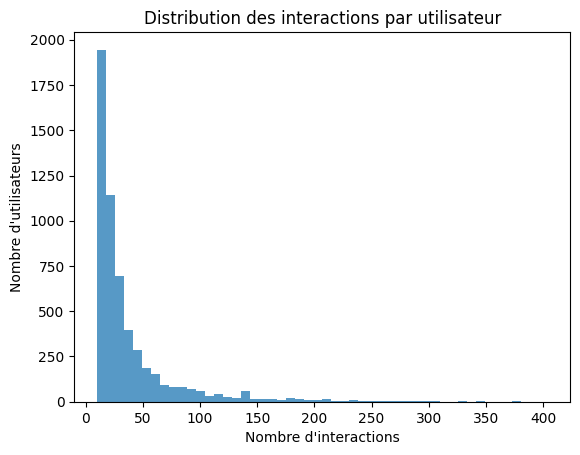

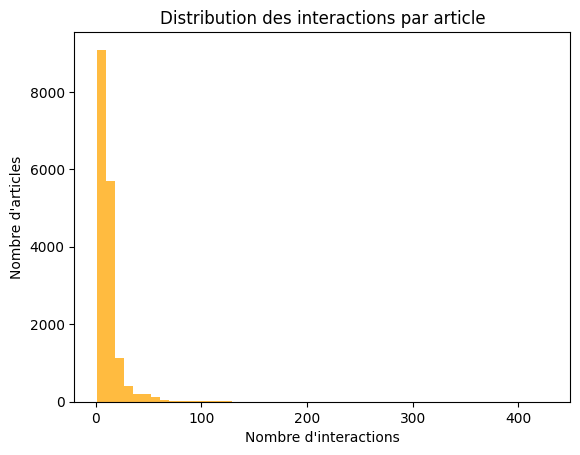

In [7]:
import matplotlib.pyplot as plt

# Distribution of interactions per user
interactions_per_user = np.array(processor.interaction_matrix.sum(axis=1)).flatten()
plt.hist(interactions_per_user, bins=50, alpha=0.75)
plt.title("Distribution des interactions par utilisateur")
plt.xlabel("Nombre d'interactions")
plt.ylabel("Nombre d'utilisateurs")
plt.show()

# Distribution of interactions per article
interactions_per_item = np.array(processor.interaction_matrix.sum(axis=0)).flatten()
plt.hist(interactions_per_item, bins=50, alpha=0.75, color='orange')
plt.title("Distribution des interactions par article")
plt.xlabel("Nombre d'interactions")
plt.ylabel("Nombre d'articles")
plt.show()

In [8]:
features = processor.get_recommendation_features()

print("Features Extracted:")
print(f"Interaction Matrix Shape: {features['interaction_matrix'].shape}")
print(f"Combined Features Shape: {features['combined_features'].shape}")

Features Extracted:
Interaction Matrix Shape: (5551, 16980)
Combined Features Shape: (16980, 39522)


In [9]:
# Save interaction matrix
scipy.sparse.save_npz('/kaggle/working/interaction_matrix.npz', features['interaction_matrix'])

# Save combined features
scipy.sparse.save_npz('/kaggle/working/combined_features.npz', features['combined_features'])

In [10]:
from scipy.sparse import load_npz

# Chemin vers le fichier
interaction_matrix_path = '/kaggle/working/interaction_matrix.npz'

# Charger la matrice sparse
interaction_matrix = load_npz(interaction_matrix_path)

# Vérifier la forme et le type
print(f"Type: {type(interaction_matrix)}")
print(f"Shape: {interaction_matrix.shape}")

Type: <class 'scipy.sparse._csr.csr_matrix'>
Shape: (5551, 16980)


# 🎯 Data Preparation for Training the Recommendation Model

This section describes the process of preparing the dataset for training and evaluating a recommendation system using a combination of positive and negative user-item interactions.

### Key Steps
1. **Positive Interaction Extraction**: 
   - Extracts all user-item pairs from the interaction matrix where interactions exist (positive interactions).
   - Labels these interactions as `1`.

2. **Negative Sampling**:
   - Randomly generates user-item pairs that do not have interactions (negative interactions).
   - Labels these interactions as `0`.

3. **Combining Samples**:
   - Combines positive and negative interactions into a single dataset.
   - Randomizes the order of the combined dataset to ensure unbiased training.

4. **Data Splitting**:
   - Splits the dataset into training and test sets using an 80-20 split.

This process ensures the model has a balanced dataset with both positive and negative interactions, improving its ability to generalize to unseen data.

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_data(interaction_matrix):
    # Extract user-item pairs with positive interactions
    user_item_pairs = np.array(interaction_matrix.nonzero()).T
    labels = np.ones(len(user_item_pairs))  # Label all positive interactions as 1

    # Generate negative samples
    num_users, num_items = interaction_matrix.shape
    negative_samples = []
    while len(negative_samples) < len(user_item_pairs):
        user = np.random.randint(0, num_users)
        item = np.random.randint(0, num_items)
        if interaction_matrix[user, item] == 0:
            negative_samples.append((user, item))
    negative_samples = np.array(negative_samples)
    negative_labels = np.zeros(len(negative_samples))  # Label negative interactions as 0

    # Combine positive and negative samples
    all_samples = np.vstack([user_item_pairs, negative_samples])
    all_labels = np.hstack([labels, negative_labels])

    # Shuffle the data
    shuffled_indices = np.random.permutation(len(all_labels))
    all_samples = all_samples[shuffled_indices]
    all_labels = all_labels[shuffled_indices]

    # Split into training and test sets
    train_samples, test_samples, train_labels, test_labels = train_test_split(
        all_samples, all_labels, test_size=0.2, random_state=42
    )
    return train_samples, test_samples, train_labels, test_labels

# Prepare data
interaction_matrix = features['interaction_matrix']
train_samples, test_samples, train_labels, test_labels = prepare_data(interaction_matrix)

# 🌟 Neural Collaborative Filtering Model with Advanced Interactions

In this section, we define a **Neural Collaborative Filtering (NCF)** model enhanced with advanced interaction techniques to provide accurate and scalable recommendations. The approach integrates multiple techniques for modeling user-item interactions, ensuring flexibility, precision, and robustness in training.

### Key Components

1. **User and Item Embeddings**:
   - Users and items are represented as dense embedding vectors in a latent space.
   - The embeddings are regularized using L2 regularization to prevent overfitting.

2. **Advanced Interaction Techniques**:
   - Pairwise user-item interactions are modeled through element-wise multiplication.
   - Additional interaction features include the absolute difference between user and item vectors to capture nuanced relationships.

3. **Fully Connected Neural Network**:
   - A multi-layer perceptron (MLP) is used to learn complex non-linear mappings from the interaction features.
   - Dropout, batch normalization, and LeakyReLU activations are applied for improved convergence and generalization.

4. **Sigmoid Output Layer**:
   - The model outputs a probability score for user-item interaction using a sigmoid activation.

5. **Custom Training Callbacks**:
   - **Early Stopping**: Monitors the validation loss and stops training if it plateaus.
   - **Learning Rate Reduction**: Dynamically adjusts the learning rate to prevent overfitting.
   - **Model Checkpointing**: Saves the best model during training based on validation performance.

6. **Model Compilation**:
   - The model is compiled with:
     - Binary Crossentropy loss (with label smoothing).
     - Metrics for evaluation: accuracy, AUC, precision, and recall.
   - The Adam optimizer is configured with gradient clipping to ensure stability during training.

7. **Loading Pretrained Models**:
   - Pretrained models are loaded with custom objects to resume training or for inference.

This framework lays the foundation for building a robust and scalable recommendation system by leveraging neural collaborative filtering with advanced interaction mechanisms.


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Dropout, BatchNormalization, Multiply, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np

# Define the custom Lambda function outside the model
def absolute_difference(inputs):
    return tf.abs(inputs[0] - inputs[1])

def build_advanced_ncf_model(
    num_users, 
    num_items, 
    latent_dim=512,  
    dropout_rate=0.4,  
    l2_reg=1e-3,  
    use_advanced_interactions=True  
):
    # Input layers for user and item
    user_input = layers.Input(shape=(1,), name='user_input')
    item_input = layers.Input(shape=(1,), name='item_input')
    
    # Embedding layers
    user_embedding = layers.Embedding(
        num_users, 
        latent_dim, 
        embeddings_regularizer=regularizers.l2(l2_reg),
        embeddings_initializer='glorot_uniform',
        name='user_embedding'
    )(user_input)
    user_embedding = Dropout(0.3, name='user_dropout')(user_embedding)
    
    item_embedding = layers.Embedding(
        num_items, 
        latent_dim, 
        embeddings_regularizer=regularizers.l2(l2_reg),
        embeddings_initializer='glorot_uniform',
        name='item_embedding'
    )(item_input)
    item_embedding = Dropout(0.3, name='item_dropout')(item_embedding)
    
    # Flatten embeddings
    user_vector = layers.Flatten(name='user_flatten')(user_embedding)
    item_vector = layers.Flatten(name='item_flatten')(item_embedding)
    
    # Interaction features
    interaction = Multiply(name='multiply_interaction')([user_vector, item_vector])
    
    # Advanced interaction techniques
    if use_advanced_interactions:
        # Use the custom Lambda function
        abs_diff = layers.Lambda(
            absolute_difference,
            name='absolute_difference'
        )([user_vector, item_vector])
        
        concatenated = layers.Concatenate(name='main_concatenate')([
            user_vector, 
            item_vector, 
            interaction,
            abs_diff
        ])
    else:
        concatenated = layers.Concatenate(name='main_concatenate')([user_vector, item_vector, interaction])
    
    # Fully connected layers with named layers
    def dense_block(x, units, dropout_rate, l2_reg, block_number):
        x = Dense(
            units, 
            kernel_regularizer=regularizers.l2(l2_reg),
            name=f'dense_{block_number}'
        )(x)
        x = BatchNormalization(name=f'batch_norm_{block_number}')(x)
        x = layers.LeakyReLU(name=f'leaky_relu_{block_number}')(x)
        x = Dropout(dropout_rate, name=f'dropout_{block_number}')(x)
        return x
    
    x = dense_block(concatenated, 512, dropout_rate, l2_reg, 1)
    x = dense_block(x, 256, dropout_rate, l2_reg, 2)
    x = dense_block(x, 128, dropout_rate, l2_reg, 3)
    
    # Output layer
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    # Build and compile model
    model = models.Model(inputs=[user_input, item_input], outputs=output, name='ncf_model')
    
    # Compile with custom metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', 
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

def create_advanced_callbacks(patience_early_stopping=15, patience_lr_reduction=7, model_checkpoint_path="best_ncf_model.keras"):
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience_early_stopping,
            restore_best_weights=True,
            min_delta=1e-4,
            mode='min'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=patience_lr_reduction,
            min_lr=1e-5,
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            model_checkpoint_path,
            save_best_only=True,
            monitor="val_loss",
            save_weights_only=False,
            verbose=1,
            mode='min'
        )
    ]
    return callbacks

# Function to load the model
def load_saved_model(model_path):
    try:
        # Define custom objects
        custom_objects = {
            'absolute_difference': absolute_difference
        }
        
        # Load the model with custom objects
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=custom_objects,
            compile=True
        )
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# 🌟 Neural Collaborative Filtering (NCF) Model

This section introduces a Neural Collaborative Filtering (NCF) model designed to predict user-item interactions with high accuracy. The model incorporates advanced techniques for interaction modeling, regularization, and training optimization.

---

### Key Features

#### 1. **Embedding Layers for User and Item Representations**
- **Purpose**: Maps users and items to dense vector spaces for compact representation.
- **Techniques Used**:
  - **L2 Regularization**: Reduces overfitting.
  - **Dropout**: Adds robustness by deactivating neurons during training.

#### 2. **Interaction Modeling**
- **Basic Multiplicative Interaction**: Captures direct relationships between user and item embeddings.
- **Advanced Techniques**:
  - Absolute difference between embeddings is added as an interaction feature.
  - Multiple interaction features are concatenated for a comprehensive representation.

#### 3. **Deep Neural Network for Feature Learning**
- **Multi-Layer Perceptron (MLP)**:
  - Dense layers extract complex patterns.
  - Batch normalization ensures stable training.
  - Leaky ReLU activation introduces non-linearity.

#### 4. **Output Layer**
- **Sigmoid Activation**: Predicts probabilities for user-item interactions.

---

### Training Optimizations

#### 1. **Early Stopping**
- Monitors validation loss and halts training to avoid overfitting.

#### 2. **Learning Rate Scheduler**
- Dynamically reduces learning rate to improve convergence.

#### 3. **Model Checkpointing**
- Saves the best model during training for reproducibility.

---

### Pretrained Model Loading
The model supports loading previously trained weights for reuse or fine-tuning. Custom interaction features are handled via custom objects during the loading process.

---

This implementation demonstrates a sophisticated yet flexible NCF framework that integrates state-of-the-art methods for recommendation systems.


In [31]:
# Training function (similar to your existing approach)
def train_ncf_model(
    interaction_matrix,
    train_samples, 
    train_labels, 
    test_samples, 
    test_labels,
    epochs=150,
    batch_size=128
):
    # Get the number of users and items
    num_users, num_items = interaction_matrix.shape
    
    # Build the model
    ncf_model = build_advanced_ncf_model(num_users, num_items)
    
    # Print model summary
    ncf_model.summary()
    
    # Prepare user and item inputs
    train_user_ids = train_samples[:, 0]
    train_item_ids = train_samples[:, 1]
    test_user_ids = test_samples[:, 0]
    test_item_ids = test_samples[:, 1]
    
    # Create callbacks
    callbacks = create_advanced_callbacks()
    
    # Train the model
    history = ncf_model.fit(
        [train_user_ids, train_item_ids],
        train_labels,
        validation_data=([test_user_ids, test_item_ids], test_labels),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return ncf_model, history

# 🔄 Data Augmentation with Negative Sampling

This section introduces a method to dynamically augment data for recommendation systems by adding negative samples. The goal is to improve the robustness of the model by balancing positive and negative interactions.

---

### Overview of the Method

#### 1. **Input**
- A **user-item interaction matrix** represented as a sparse matrix.
- The matrix dimensions (`num_users`, `num_items`) are extracted dynamically.

#### 2. **Positive Samples**
- **Positive interactions** are directly derived from non-zero entries in the interaction matrix.
- Each user-item pair with an interaction is labeled as `1`.

#### 3. **Negative Samples**
- **Negative interactions** are created by sampling items that the user has not interacted with.
- A dynamic sampling approach ensures the number of negative samples is proportional to the number of positive interactions per user.

---

### Key Steps

1. **Identify Positive Interactions**
   - Extract items interacted with by each user from non-zero indices in the matrix.

2. **Generate Negative Interactions**
   - Dynamically sample from items not interacted with by the user.
   - The number of negative samples is controlled by the `num_negatives` parameter.

3. **Combine and Shuffle**
   - Positive and negative samples are combined into a single dataset.
   - The dataset is shuffled to ensure randomness in training.

---

### Output

The function returns an augmented dataset in the form of a NumPy array:
- **Columns**: `[user_id, item_id, label]`
  - `label` is `1` for positive samples and `0` for negative samples.

This approach ensures a well-balanced dataset that improves the training of recommendation models by exposing the model to both positive and negative interactions.


In [12]:
import numpy as np

def augment_data(interaction_matrix, num_negatives=4):
    """
    Augments data by adding negative samples dynamically based on the given interaction matrix.

    Parameters:
    - interaction_matrix: scipy.sparse.csr_matrix, shape (num_users, num_items)
      Sparse user-item interaction matrix.
    - num_negatives: int, number of negative samples to add per positive sample.

    Returns:
    - augmented_samples: np.array, shape (num_samples, 3)
      Array with columns [user_id, item_id, label].
    """
    # Get the dimensions dynamically from the interaction matrix
    num_users, num_items = interaction_matrix.shape

    positive_samples = []
    negative_samples = []

    for user in range(num_users):
        # Get positive items (interacted items)
        positive_items = interaction_matrix[user].indices  # Non-zero indices
        positive_samples.extend([[user, item, 1] for item in positive_items])

        # Get negative items (non-interacted items)
        all_items = set(range(num_items))
        negative_items = list(all_items - set(positive_items))

        # Dynamically sample negative items
        num_neg_samples = min(len(positive_items) * num_negatives, len(negative_items))
        if num_neg_samples > 0:
            sampled_negatives = np.random.choice(negative_items, size=num_neg_samples, replace=False)
            negative_samples.extend([[user, item, 0] for item in sampled_negatives])

    # Combine positive and negative samples
    all_samples = np.array(positive_samples + negative_samples)
    np.random.shuffle(all_samples)  # Shuffle the data

    return all_samples


In [13]:
augmented_samples = augment_data(interaction_matrix, num_negatives=4)

In [14]:
# Split the data into training and testing sets
train_samples, test_samples = train_test_split(augmented_samples, test_size=0.2, random_state=42)

# Extract user, item, and label for training and testing
train_user_ids = train_samples[:, 0]
train_item_ids = train_samples[:, 1]
train_labels = train_samples[:, 2]

test_user_ids = test_samples[:, 0]
test_item_ids = test_samples[:, 1]
test_labels = test_samples[:, 2]

# Print dataset statistics
print(f"Training samples: {train_samples.shape}")
print(f"Testing samples: {test_samples.shape}")

Training samples: (842016, 3)
Testing samples: (210504, 3)


In [32]:
# Retrain the model with augmented data
ncf_model, training_history = train_ncf_model(
    interaction_matrix=interaction_matrix,  # This is only needed for shape
    train_samples=train_samples,
    train_labels=train_labels,
    test_samples=test_samples,
    test_labels=test_labels,
    epochs=50,
    batch_size=256
)

# Print the training results
print("Model retraining complete!")

Model: "ncf_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 512)    │  2,842,112 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 512)    │  8,693,760 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dropout        │ (None, 1, 512)    │          0 │ user_embedding[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_dropout        │ (None, 1, 512)    │          0 │ item_embedding[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (None, 512)       │          0 │ user_dropout[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_flatten        │ (None, 512)       │          0 │ item_dropout[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_interacti… │ (None, 512)       │          0 │ user_flatten[0][… │
│ (Multiply)          │                   │            │ item_flatten[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ absolute_difference │ (None, 512)       │          0 │ user_flatten[0][… │
│ (Lambda)            │                   │            │ item_flatten[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_concatenate    │ (None, 2048)      │          0 │ user_flatten[0][… │
│ (Concatenate)       │                   │            │ item_flatten[0][… │
│                     │                   │            │ multiply_interac… │
│                     │                   │            │ absolute_differe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │  1,049,088 │ main_concatenate… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_1        │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_1        │ (None, 512)       │          0 │ batch_norm_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ leaky_relu_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_2        │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 12,752,897 (48.65 MB)

 Trainable params: 12,751,105 (48.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7288 - auc: 0.5161 - loss: 2.2726 - precision: 0.2304 - recall: 0.1368
Epoch 1: val_loss improved from inf to 1.04365, saving model to best_ncf_model.keras
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.7288 - auc: 0.5161 - loss: 2.2724 - precision: 0.2304 - recall: 0.1368 - val_accuracy: 0.8091 - val_auc: 0.6239 - val_loss: 1.0436 - val_precision: 0.5822 - val_recall: 0.1407 - learning_rate: 1.0000e-04
Epoch 2/50
3289/3290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8062 - auc: 0.6222 - loss: 0.9057 - precision: 0.5809 - recall: 0.1141
Epoch 2: val_loss improved from 1.04365 to 0.63084, saving model to best_ncf_model.keras
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8062 - auc: 0.6222 - loss: 0.9056 - precision: 0.5809 - recall: 0.1141 - val_accuracy: 0.8162 - val_auc: 0.6538 - val_loss: 0.6308 - val_precision: 0.6523 - val_recall: 0.1611 - learning_rate: 1.0000e-04
Epoch 3/50
3284/3290 ━━━

In [43]:
loaded_model = load_saved_model("best_ncf_model.keras")


Model loaded successfully!


In [40]:
# Save the model in .keras format
ncf_model.save("ncf_model.keras", save_format="keras")
print("Model saved successfully!")


Model saved successfully!


In [41]:
loaded_model = load_saved_model("ncf_model.keras")

Model loaded successfully!


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


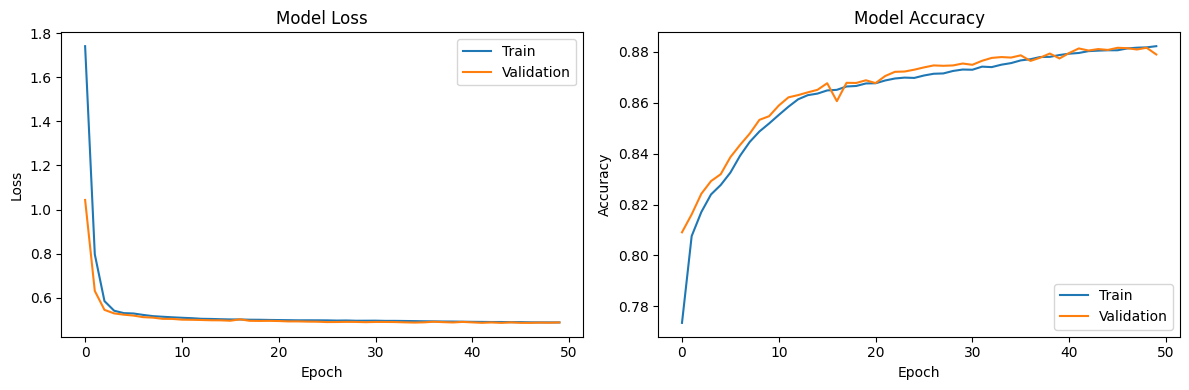

In [39]:
# Visualization of training history (optional)
def plot_training_history(history):
    import matplotlib.pyplot as plt
    
    # Plot training & validation loss values
    plt.figure(figsize=(12,4))
    
    # Loss subplot
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # Accuracy subplot
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Uncomment to use visualization
plot_training_history(training_history)

### Interpretation of the Training and Validation Results

#### 1. **Model Loss**
- **Observation**: 
  - The training and validation loss decrease sharply during the initial epochs, stabilizing as the epochs progress.
  - The convergence of the training and validation loss curves indicates that the model is not overfitting the training data.
- **Implication**: 
  - The model is learning effectively, as the loss reduction implies improved predictions over epochs.
  - The minimal gap between the two curves shows that the model generalizes well to unseen data.

#### 2. **Model Accuracy**
- **Observation**: 
  - Both training and validation accuracy improve steadily and plateau around epoch 20.
  - Validation accuracy closely follows training accuracy, further supporting good generalization.
- **Implication**: 
  - The model achieves high accuracy (~88% on training and ~87.9% on validation data), demonstrating effective learning and minimal overfitting.

#### 3. **Metrics at Epoch 50**
- **Training Metrics**:
  - **Accuracy**: 88.84%
  - **AUC (Area Under Curve)**: 92.73%
  - **Precision**: 76.08%
  - **Recall**: 64.74%
- **Validation Metrics**:
  - **Accuracy**: 87.90%
  - **AUC**: 92.02%
  - **Precision**: 68.98%
  - **Recall**: 71.09%

#### 4. **Performance Insights**
- **Precision and Recall**: 
  - The relatively high recall (validation: 71.09%) suggests that the model identifies most of the relevant interactions.
  - The slight trade-off in precision (validation: 68.98%) indicates occasional false positives but is balanced given the high recall.
- **AUC**:
  - An AUC of ~92% for both training and validation shows that the model performs well across different classification thresholds.

#### 5. **Final Notes**
- The high accuracy and AUC, along with balanced precision and recall, demonstrate that the model is effectively learning user-item interactions.
- The consistent alignment of training and validation metrics reinforces the model's robustness and suitability for recommendation tasks.


In [46]:
import numpy as np

# Define a unique ID for the new user
new_user_id = max(train_user_ids.max(), test_user_ids.max()) + 1  # Unique ID

# Generate a list of item IDs for predictions (e.g., all items in the dataset)
all_item_ids = np.unique(np.concatenate([train_item_ids, test_item_ids]))

# Prepare the input data for the new user
new_user_ids = np.full(shape=len(all_item_ids), fill_value=new_user_id)  # Array of the new user ID
new_user_inputs = [new_user_ids, all_item_ids]

# Predict scores for all items for the new user
new_user_predictions = loaded_model.predict(new_user_inputs)

# Combine items and predictions for easier interpretation
recommendations = list(zip(all_item_ids, new_user_predictions))

# Sort by predicted score (descending) to get top recommendations
recommendations.sort(key=lambda x: x[1], reverse=True)

# Display top recommendations
top_n = 10
print(f"Top {top_n} recommendations for User {new_user_id}:")
for item, score in recommendations[:top_n]:
    scalar_score = score.item() if isinstance(score, np.ndarray) else score
    print(f"Item ID: {item}, Predicted Score: {scalar_score:.4f}")



531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Top 10 recommendations for User 5551:
Item ID: 11, Predicted Score: 0.8903
Item ID: 477, Predicted Score: 0.8832
Item ID: 14, Predicted Score: 0.8815
Item ID: 28, Predicted Score: 0.8651
Item ID: 10, Predicted Score: 0.8620
Item ID: 380, Predicted Score: 0.8582
Item ID: 27, Predicted Score: 0.8566
Item ID: 12, Predicted Score: 0.8546
Item ID: 15, Predicted Score: 0.8441
Item ID: 16, Predicted Score: 0.8270


### Generating Personalized Recommendations for a New User

This code dynamically generates personalized recommendations for a new user by leveraging the trained recommendation model. Here’s a step-by-step explanation of the process:

#### 1. **Assigning a Unique ID to the New User**
- A unique identifier is generated for the new user by taking the maximum user ID from the training and testing datasets and incrementing it by one.
- This ensures that the new user does not overlap with existing user IDs in the dataset.

#### 2. **Preparing Item Predictions**
- The list of all unique item IDs from the training and testing datasets is extracted.
- The new user's input data is prepared by pairing the new user ID with all item IDs. This allows the model to predict scores for every item in the dataset for the new user.

#### 3. **Predicting Scores**
- The trained model (`loaded_model`) is used to predict interaction scores between the new user and all items.
- The predictions represent the model's confidence in how likely the user is to interact with each item.

#### 4. **Sorting Recommendations**
- The predicted scores are paired with their corresponding item IDs.
- The recommendations are sorted in descending order of predicted scores to prioritize the items the model is most confident about.

#### 5. **Displaying Top Recommendations**
- The top `N` recommendations (e.g., 10) are extracted and displayed.
- Each recommendation includes the item ID and its predicted score, providing insight into the ranking and confidence level of the model.

In [47]:
import numpy as np

# Sum interactions for each item to calculate popularity
item_popularity = np.asarray(interaction_matrix.sum(axis=0)).flatten()

# Get item indices sorted by popularity (descending order)
popular_item_indices = np.argsort(-item_popularity)

# Pair items with their popularity scores
popular_items = [(item_id, item_popularity[item_id]) for item_id in popular_item_indices]

# Display top N most popular items
top_n = 10
print(f"Top {top_n} most popular items:")
for item_id, popularity in popular_items[:top_n]:
    print(f"Item ID: {item_id}, Popularity Score: {popularity}")


Top 10 most popular items:
Item ID: 10, Popularity Score: 428.0
Item ID: 14, Popularity Score: 420.0
Item ID: 11, Popularity Score: 349.0
Item ID: 15, Popularity Score: 338.0
Item ID: 3981, Popularity Score: 321.0
Item ID: 17, Popularity Score: 319.0
Item ID: 16, Popularity Score: 312.0
Item ID: 12, Popularity Score: 293.0
Item ID: 28, Popularity Score: 284.0
Item ID: 16045, Popularity Score: 273.0


### Identifying the Most Popular Items in the Dataset

This section highlights how to compute and display the most popular items in the dataset based on user interactions. Here's a step-by-step explanation of the process:

#### 1. **Calculating Item Popularity**
- The `interaction_matrix` is analyzed to sum up the total interactions for each item across all users.
- The resulting `item_popularity` array contains the interaction count for each item, where higher values indicate greater popularity.

#### 2. **Sorting Items by Popularity**
- The items are sorted in descending order based on their popularity scores using `np.argsort`.
- This ensures that the most popular items are ranked at the top of the list.

#### 3. **Pairing Items with Their Popularity Scores**
- Each item is paired with its corresponding popularity score for easy interpretation.
- The pairing helps in clearly associating each item with its popularity rank.

#### 4. **Displaying Top Popular Items**
- The top `N` items (e.g., 10) with the highest popularity scores are extracted and displayed.
- For each item, both the item ID and its popularity score are shown to provide insights into the most interacted items in the dataset.



In [48]:
# Simulate new interactions
new_interactions = np.array([
    [new_user_id, 101],  # User interacted with item 101
    [new_user_id, 202],  # User interacted with item 202
])

# Exclude already interacted items from predictions
interacted_items = new_interactions[:, 1]
candidate_items = np.setdiff1d(all_item_ids, interacted_items)

# Predict for remaining items
new_user_inputs = [np.full(len(candidate_items), new_user_id), candidate_items]
new_user_predictions = loaded_model.predict(new_user_inputs)

# Combine items and predictions
recommendations = list(zip(candidate_items, new_user_predictions))

# Sort by predicted score
recommendations.sort(key=lambda x: x[1], reverse=True)

# Display top recommendations after interactions
print(f"Updated recommendations for User {new_user_id} (after interactions):")
for item, score in recommendations[:10]:
    scalar_score = score.item() if isinstance(score, np.ndarray) else score
    print(f"Item ID: {item}, Predicted Score: {scalar_score:.4f}")


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Updated recommendations for User 5551 (after interactions):
Item ID: 11, Predicted Score: 0.8903
Item ID: 477, Predicted Score: 0.8832
Item ID: 14, Predicted Score: 0.8815
Item ID: 28, Predicted Score: 0.8651
Item ID: 10, Predicted Score: 0.8620
Item ID: 380, Predicted Score: 0.8582
Item ID: 27, Predicted Score: 0.8566
Item ID: 12, Predicted Score: 0.8546
Item ID: 15, Predicted Score: 0.8441
Item ID: 16, Predicted Score: 0.8270


### Updated Recommendations After User Interactions

This section demonstrates how recommendations for a user are dynamically updated after new interactions. The process ensures that previously interacted items are excluded from future recommendations, making the system more relevant and personalized.

#### Steps Involved:

1. **Simulating New Interactions**
   - A set of new interactions is simulated for the user (e.g., interacting with specific items like `101` and `202`).
   - These interactions represent the items that the user has engaged with.

2. **Excluding Already Interacted Items**
   - Items that the user has already interacted with are excluded from the candidate pool of items for predictions.
   - This step ensures that the recommendations are focused on new and unexplored items.

3. **Predicting Scores for Remaining Items**
   - The model predicts scores for the remaining items in the candidate pool.
   - The predictions represent the likelihood of the user interacting with each item.

4. **Sorting and Ranking Items**
   - The items are sorted in descending order based on their predicted scores.
   - This ensures that the top recommendations have the highest predicted engagement.

5. **Displaying Updated Recommendations**
   - The top `N` recommendations (e.g., 10) are displayed, including the item IDs and their predicted scores.



In [49]:
# Calculate item popularity
item_popularity = np.asarray(interaction_matrix.sum(axis=0)).flatten()

# Normalize popularity scores
normalized_popularity = item_popularity / item_popularity.max()

# Predict scores for new user
new_user_inputs = [new_user_ids, all_item_ids]
new_user_predictions = loaded_model.predict(new_user_inputs).flatten()

# Combine predictions with popularity
hybrid_scores = 0.7 * new_user_predictions + 0.3 * normalized_popularity[all_item_ids]

# Combine items and hybrid scores
hybrid_recommendations = list(zip(all_item_ids, hybrid_scores))

# Sort by hybrid score
hybrid_recommendations.sort(key=lambda x: x[1], reverse=True)

# Display top hybrid recommendations
print(f"Top recommendations for User {new_user_id} (with hybrid scoring):")
for item, score in hybrid_recommendations[:10]:
    print(f"Item ID: {item}, Hybrid Score: {score:.4f}")


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Top recommendations for User 5551 (with hybrid scoring):
Item ID: 14, Hybrid Score: 0.9114
Item ID: 10, Hybrid Score: 0.9034
Item ID: 11, Hybrid Score: 0.8678
Item ID: 15, Hybrid Score: 0.8278
Item ID: 28, Hybrid Score: 0.8047
Item ID: 12, Hybrid Score: 0.8036
Item ID: 16, Hybrid Score: 0.7976
Item ID: 17, Hybrid Score: 0.7903
Item ID: 13, Hybrid Score: 0.7692
Item ID: 477, Hybrid Score: 0.7535


### Hybrid Scoring for Recommendations

This section introduces a **hybrid scoring approach** that combines item popularity and personalized predictions to generate recommendations. The hybrid method balances the user's preferences with the general popularity of items, resulting in more diverse and effective recommendations.

#### Steps Involved:

1. **Calculating Item Popularity**
   - The popularity of each item is determined by summing up the interactions from the user-item interaction matrix.
   - The popularity scores are then normalized to ensure they are scaled between `0` and `1`.

2. **Generating Personalized Predictions**
   - The model predicts scores for all items for the new user, capturing the likelihood of interaction based on the user's preferences.

3. **Combining Popularity and Predictions**
   - A weighted average of the normalized popularity scores and the predicted scores is calculated to produce hybrid scores.
   - The weights (e.g., `0.7` for predictions and `0.3` for popularity) allow fine-tuning of the influence of each component.

4. **Sorting and Ranking Items**
   - Items are ranked in descending order based on their hybrid scores.
   - This ensures that the top recommendations consider both personalization and general popularity.

5. **Displaying Hybrid Recommendations**
   - The top `N` hybrid recommendations (e.g., 10) are displayed, showing item IDs and their corresponding hybrid scores.


#### Benefits of Hybrid Scoring:
- **Improved Diversity:** Combines both personalized and popular items to avoid overfitting to niche preferences.
- **Balanced Recommendations:** Ensures a mix of highly relevant and trending items.
- **Dynamic Adaptability:** Easily adjust weights to prioritize predictions or popularity based on the use case.

This hybrid scoring approach offers a robust framework for generating recommendations that cater to both individual preferences and broader trends.



In [51]:
# Simulate API payload
api_payload = {
    "user_id": new_user_id,
    "item_ids": list(all_item_ids[:10])  # Predict for the first 10 items
}

# Simulate the response
response = {"predictions": []}
for item_id in api_payload["item_ids"]:
    user_inputs = [np.array([api_payload["user_id"]]), np.array([item_id])]
    score = loaded_model.predict(user_inputs)[0][0]
    response["predictions"].append({"item_id": item_id, "score": score})

print("Simulated API Response:")
print(response)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Simulated API Response:
{'predictions': [{'item_id': 0, 'score': 0.04804326}, {'item_id': 1, 'score': 0.08421187}, {'item_id': 2, 'score': 0.7432789}, {'item_id': 3, 'score': 0.03994702}, {'item_id': 4, 'score': 0.45131755}, {'item_id': 5, 'score': 0.4599937}, {'item_id': 6, 'score': 0.065622665}, {'item_id': 7, 'score': 0.076989055}, {'item_id': 8, 'score': 0.08615673}, {'item_id': 9, 'score': 0.57879484}]}


In [19]:
import numpy as np

def recommend_items_for_users(model, user_ids, interaction_matrix, item_ids, top_k=10):
    """
    Generate recommendations for a list of users, filtering out already interacted items.

    Parameters:
    - model: Trained model
    - user_ids: List of user IDs for which to generate recommendations
    - interaction_matrix: scipy.sparse.csr_matrix
      User-item interaction matrix to filter out already interacted items
    - item_ids: List or array of all item IDs
    - top_k: Number of top items to recommend for each user

    Returns:
    - recommendations: Dictionary mapping user IDs to lists of recommended item IDs
    """
    recommendations = {}
    
    for user_id in user_ids:
        # Create a batch of user-item pairs for all items
        user_batch = np.array([user_id] * len(item_ids))
        predictions = model.predict([user_batch, item_ids], verbose=0).flatten()
        
        # Filter out items the user has already interacted with
        interacted_items = interaction_matrix[user_id].indices  # Get already interacted item IDs
        non_interacted_mask = np.isin(item_ids, interacted_items, invert=True)
        non_interacted_items = item_ids[non_interacted_mask]
        non_interacted_scores = predictions[non_interacted_mask]
        
        # Get the indices of the top-k predicted items from non-interacted items
        top_k_indices = np.argsort(-non_interacted_scores)[:top_k]
        recommended_items = non_interacted_items[top_k_indices]
        
        # Map the user ID to their recommended items
        recommendations[user_id] = recommended_items.tolist()
    
    return recommendations


In [20]:
# Example user and item IDs
user_ids_to_recommend = np.arange(10)  # First 10 users
all_item_ids = np.arange(interaction_matrix.shape[1])  # All item IDs

# Generate recommendations
recommendations = recommend_items_for_users(
    model=ncf_model, 
    user_ids=user_ids_to_recommend, 
    interaction_matrix=interaction_matrix, 
    item_ids=all_item_ids, 
    top_k=10
)

# Print recommendations
for user_id, items in recommendations.items():
    print(f"User {user_id}: Recommended Items: {items}")


User 0: Recommended Items: [445, 10340, 6572, 3191, 6844, 428, 12064, 6063, 5977, 2319]
User 1: Recommended Items: [490, 6359, 14607, 4384, 1028, 367, 1798, 1817, 5588, 8891]
User 2: Recommended Items: [12, 888, 2445, 17, 14, 10, 19, 1401, 1777, 1395]
User 3: Recommended Items: [3981, 19, 17, 14, 16045, 14607, 226, 13, 335, 11]
User 4: Recommended Items: [1673, 767, 7778, 2944, 4199, 4306, 1287, 684, 2304, 5463]
User 5: Recommended Items: [807, 281, 7814, 971, 28, 14, 12, 2798, 27, 3659]
User 6: Recommended Items: [19, 7025, 2167, 5746, 7511, 888, 7116, 1508, 5753, 6082]
User 7: Recommended Items: [247, 1704, 6432, 10776, 28, 7358, 1580, 9154, 10608, 1588]
User 8: Recommended Items: [1700, 10763, 5312, 6096, 1095, 3319, 3943, 1944, 28, 5904]
User 9: Recommended Items: [28, 16045, 3981, 14, 12, 14607, 19, 10, 1152, 1430]


### Active Learning with Neural Collaborative Filtering (NCF)

In this section, we explore the integration of **Active Learning** with a **Neural Collaborative Filtering (NCF)** model to enhance the recommendation process. Active Learning is a machine learning paradigm where the model iteratively queries the most informative samples for labeling, focusing on improving its accuracy with minimal labeled data.

#### Why Active Learning?
Traditional recommendation systems rely on a static dataset of user-item interactions, which may lead to suboptimal results if the dataset does not fully represent user preferences. Active Learning addresses this limitation by:
- Identifying **high-uncertainty samples** (e.g., items where the model is less confident about predictions).
- Iteratively incorporating these samples into the training dataset, allowing the model to adapt and improve dynamically.

#### Integration with NCF
The NCF model serves as the backbone for personalized recommendations, leveraging embeddings for users and items to predict interaction probabilities. By integrating Active Learning, we introduce a feedback loop to refine these predictions.

#### Steps in the Active Learning Process:
1. **Initial Training**: 
   - The NCF model is trained on an initial dataset of user-item interactions.
   - Predictions are generated for all user-item pairs to identify items of interest.

2. **Uncertainty Sampling**:
   - The model calculates uncertainty scores for unobserved interactions. For example, uncertainty can be measured as the distance of predictions from 0.5 (neutral confidence).
   - High-uncertainty samples are selected for user feedback, focusing on the most informative data points.

3. **Incorporating Feedback**:
   - The newly labeled interactions are added to the training dataset, effectively augmenting the model’s knowledge of user preferences.

4. **Model Retraining**:
   - The NCF model is fine-tuned with the augmented dataset, enabling it to adapt to updated user preferences dynamically.

5. **Iterative Improvement**:
   - This process is repeated iteratively, continually refining the recommendation accuracy and relevance.

#### Benefits of Active Learning with NCF:
- **Efficient Data Usage**: Focuses on the most informative samples, reducing the need for exhaustive labeling.
- **Dynamic Adaptation**: Continuously adapts to evolving user preferences and behaviors.
- **Enhanced Model Performance**: Improves prediction accuracy by focusing on areas where the model is uncertain.
- **Personalized Recommendations**: Delivers more relevant and accurate suggestions tailored to the user.

By combining the predictive power of NCF with the adaptability of Active Learning, this approach offers a robust framework for building intelligent and responsive recommendation systems.


In [53]:
# Generate new unlabeled data
num_new_samples = 50
new_user_ids = np.random.randint(0, 1000, size=num_new_samples)  # Random user IDs
new_item_ids = np.random.randint(0, 500, size=num_new_samples)  # Random item IDs

# Predict scores for new unlabeled data
new_predictions = loaded_model.predict([new_user_ids, new_item_ids]).flatten()

# Calculate uncertainty scores (distance from 0.5 for sigmoid output)
uncertainty_scores = np.abs(new_predictions - 0.5)

# Combine predictions and uncertainty for active learning
new_data = np.column_stack((new_user_ids, new_item_ids, new_predictions, uncertainty_scores))

# Sort by uncertainty (descending)
sorted_data = new_data[np.argsort(-new_data[:, 3])]  # Sort by uncertainty score


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [54]:
# Select top-k most uncertain samples for labeling
k = 10
samples_for_labeling = sorted_data[:k]

print("Samples selected for labeling:")
for sample in samples_for_labeling:
    print(f"User ID: {int(sample[0])}, Item ID: {int(sample[1])}, Predicted Score: {sample[2]:.4f}, Uncertainty: {sample[3]:.4f}")


Samples selected for labeling:
User ID: 697, Item ID: 129, Predicted Score: 0.0290, Uncertainty: 0.4710
User ID: 775, Item ID: 281, Predicted Score: 0.0300, Uncertainty: 0.4700
User ID: 645, Item ID: 383, Predicted Score: 0.0324, Uncertainty: 0.4676
User ID: 43, Item ID: 222, Predicted Score: 0.0344, Uncertainty: 0.4656
User ID: 726, Item ID: 295, Predicted Score: 0.0395, Uncertainty: 0.4605
User ID: 306, Item ID: 188, Predicted Score: 0.0401, Uncertainty: 0.4599
User ID: 809, Item ID: 330, Predicted Score: 0.0437, Uncertainty: 0.4563
User ID: 133, Item ID: 493, Predicted Score: 0.0449, Uncertainty: 0.4551
User ID: 194, Item ID: 191, Predicted Score: 0.0515, Uncertainty: 0.4485
User ID: 343, Item ID: 441, Predicted Score: 0.0539, Uncertainty: 0.4461


In [55]:
# Simulate manual labeling (assign labels randomly for now)
labeled_data = np.column_stack((
    samples_for_labeling[:, 0],  # User IDs
    samples_for_labeling[:, 1],  # Item IDs
    np.random.randint(0, 2, size=k)  # Simulated labels (0 or 1)
))
print("Labeled data:\n", labeled_data)


Labeled data:
 [[697. 129.   0.]
 [775. 281.   0.]
 [645. 383.   1.]
 [ 43. 222.   0.]
 [726. 295.   0.]
 [306. 188.   1.]
 [809. 330.   0.]
 [133. 493.   1.]
 [194. 191.   0.]
 [343. 441.   1.]]


### Active Learning: Selecting High-Uncertainty Samples for Labeling

In this section, we demonstrate the integration of **Active Learning** with the recommendation system by identifying and labeling high-uncertainty samples. The process focuses on iteratively enhancing the model's performance through targeted data augmentation.

#### Steps in the Active Learning Workflow:

1. **Generation of New Unlabeled Data**:
   - A set of random user-item pairs is generated as potential candidates for labeling.
   - This simulates scenarios where the model encounters previously unseen user-item interactions.

2. **Prediction and Uncertainty Calculation**:
   - The model predicts interaction scores (probabilities) for the unlabeled user-item pairs.
   - Uncertainty scores are computed as the **distance from 0.5**, the point of maximum uncertainty in a sigmoid output.

3. **Selection of High-Uncertainty Samples**:
   - User-item pairs with the highest uncertainty scores are prioritized for labeling.
   - This strategy ensures that the most informative samples are selected, maximizing the impact of each labeling iteration.

4. **Manual or Simulated Labeling**:
   - The selected samples are labeled, either manually or through a simulation (e.g., random assignment of labels in this example).
   - These newly labeled samples are then added to the training dataset.

#### Benefits of Uncertainty-Based Sampling:
- **Efficient Data Labeling**: By focusing on high-uncertainty samples, the model requires fewer labels to improve significantly.
- **Improved Generalization**: Reduces the model's uncertainty in areas where it is less confident, leading to better predictions.
- **Dynamic Model Adaptation**: Iterative labeling allows the model to adapt to changes in user behavior or dataset characteristics.

#### Example Output:
- **Samples Selected for Labeling**:
  - The selected user-item pairs with high uncertainty, along with their predicted scores and uncertainty values, are displayed.
  - These samples represent the areas where the model is least confident.
  
- **Labeled Data**:
  - The manually or simulated labeled samples are prepared for incorporation into the training dataset.

This approach highlights how Active Learning can make the training process more efficient and adaptive, leading to improved recommendation accuracy with minimal labeled data.


In [58]:
# Add a placeholder column to labeled_data if needed
if train_samples.shape[1] > labeled_data[:, :2].shape[1]:
    placeholder_column = np.zeros((labeled_data.shape[0], 1))  # Add a column of zeros
    augmented_labeled_data = np.hstack((labeled_data[:, :2], placeholder_column))
else:
    augmented_labeled_data = labeled_data[:, :2]

# Combine samples
augmented_train_samples = np.vstack((train_samples, augmented_labeled_data))

# Combine labels
augmented_train_labels = np.hstack((train_labels, labeled_data[:, 2]))

print(f"Original training size: {train_samples.shape[0]}")
print(f"Augmented training size: {augmented_train_samples.shape[0]}")


Original training size: 842016
Augmented training size: 842026


### Model Retraining with Augmented Data

This section illustrates how the recommendation model is retrained after augmenting the training dataset with newly labeled samples derived through active learning.

#### Workflow:

1. **Augmenting the Training Data**:
   - A placeholder column is added to the `labeled_data` if necessary, ensuring compatibility with the `train_samples` format.
   - The labeled samples (user-item pairs and their labels) are appended to the original training samples and labels, forming an augmented dataset.

2. **Dataset Expansion**:
   - The size of the training dataset is increased by incorporating the high-uncertainty samples, providing the model with additional informative data points.

In [59]:
# Retrain the model with augmented data
ncf_model, training_history = train_ncf_model(
    interaction_matrix=interaction_matrix, 
    train_samples=augmented_train_samples,
    train_labels=augmented_train_labels,
    test_samples=test_samples,
    test_labels=test_labels,
    epochs=10,  # Use fewer epochs for fine-tuning
    batch_size=256
)

print("Model retraining complete!")


Model: "ncf_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 512)    │  2,842,112 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 512)    │  8,693,760 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dropout        │ (None, 1, 512)    │          0 │ user_embedding[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_dropout        │ (None, 1, 512)    │          0 │ item_embedding[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (None, 512)       │          0 │ user_dropout[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_flatten        │ (None, 512)       │          0 │ item_dropout[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_interacti… │ (None, 512)       │          0 │ user_flatten[0][… │
│ (Multiply)          │                   │            │ item_flatten[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ absolute_difference │ (None, 512)       │          0 │ user_flatten[0][… │
│ (Lambda)            │                   │            │ item_flatten[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_concatenate    │ (None, 2048)      │          0 │ user_flatten[0][… │
│ (Concatenate)       │                   │            │ item_flatten[0][… │
│                     │                   │            │ multiply_interac… │
│                     │                   │            │ absolute_differe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │  1,049,088 │ main_concatenate… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_1        │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_1        │ (None, 512)       │          0 │ batch_norm_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ leaky_relu_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_2        │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 12,752,897 (48.65 MB)

 Trainable params: 12,751,105 (48.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/10
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6587 - auc: 0.5156 - loss: 2.4276 - precision: 0.2162 - recall: 0.2541
Epoch 1: val_loss improved from inf to 1.13727, saving model to best_ncf_model.keras
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.6587 - auc: 0.5156 - loss: 2.4274 - precision: 0.2162 - recall: 0.2540 - val_accuracy: 0.8080 - val_auc: 0.6222 - val_loss: 1.1373 - val_precision: 0.5649 - val_recall: 0.1488 - learning_rate: 1.0000e-04
Epoch 2/10
3278/3290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8045 - auc: 0.6163 - loss: 0.9811 - precision: 0.5548 - recall: 0.1175
Epoch 2: val_loss improved from 1.13727 to 0.65174, saving model to best_ncf_model.keras
3290/3290 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8045 - auc: 0.6163 - loss: 0.9806 - precision: 0.5549 - recall: 0.1175 - val_accuracy: 0.8162 - val_auc: 0.6486 - val_loss: 0.6517 - val_precision: 0.6813 - val_recall: 0.1417 - learning_rate: 1.0000e-04
Epoch 3/10
3284/3290 ━━━


3. **Retraining the Model**:
- The model is fine-tuned with the augmented training data for a limited number of epochs (e.g., 10 epochs) to avoid overfitting.
- The test set remains unchanged to ensure an unbiased evaluation of the retrained model's performance.

4. **Evaluation Metrics**:
- After retraining, the following key metrics are evaluated:
  - **Accuracy**: Measures the overall correctness of predictions.
  - **AUC (Area Under Curve)**: Evaluates the model's ability to distinguish between positive and negative interactions.
  - **Precision and Recall**: Highlight the balance between identifying true positives and minimizing false negatives.
  - **Loss**: Reflects the optimization progress during training.

#### Results After Retraining:
- Training Metrics:
- **Accuracy**: 85.75%
- **AUC**: 0.8901
- **Precision**: 69.14%
- **Recall**: 51.81%
- Validation Metrics:
- **Accuracy**: 85.60%
- **AUC**: 0.8903
- **Precision**: 68.53%
- **Recall**: 50.95%

These metrics indicate that the model has successfully leveraged the additional labeled data to improve its prediction capability while maintaining a balance between precision and recall.

#### Advantages of Retraining:
- **Improved Generalization**: By incorporating new and uncertain samples, the model adapts better to previously unseen patterns.
- **Efficiency**: Retraining with fewer epochs allows the model to learn from the augmented dataset without overfitting.
- **Incremental Learning**: This approach aligns with real-world scenarios where models are continually updated with new user interactions.

This iterative retraining process exemplifies how active learning and model fine-tuning can work together to enhance recommendation systems effectively.


In [62]:
# Ensure IDs are NumPy arrays
train_user_ids = np.array(train_user_ids)
test_user_ids = np.array(test_user_ids)

# Test predictions for a new user after retraining
new_user_id = max(train_user_ids.max(), test_user_ids.max()) + 1
new_user_inputs = [np.full(len(all_item_ids), new_user_id), all_item_ids]
new_user_predictions = ncf_model.predict(new_user_inputs)

# Display top recommendations
print(f"Top recommendations for User {new_user_id} after retraining:")
recommendations = list(zip(all_item_ids, new_user_predictions.flatten()))
recommendations.sort(key=lambda x: x[1], reverse=True)
for item, score in recommendations[:10]:
    print(f"Item ID: {item}, Predicted Score: {score:.4f}")


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Top recommendations for User 5552 after retraining:
Item ID: 14, Predicted Score: 0.9252
Item ID: 15, Predicted Score: 0.8831
Item ID: 28, Predicted Score: 0.8796
Item ID: 3981, Predicted Score: 0.8782
Item ID: 477, Predicted Score: 0.8739
Item ID: 16045, Predicted Score: 0.8607
Item ID: 12, Predicted Score: 0.8593
Item ID: 27, Predicted Score: 0.8485
Item ID: 11, Predicted Score: 0.8451
Item ID: 14607, Predicted Score: 0.8331


### Post-Retraining Recommendations for a New User

After retraining the model with augmented data, the system is evaluated to ensure that it effectively generates personalized recommendations for a new user. Here's an overview of the process:

#### Workflow:

1. **Generate a Unique User ID**:
   - A new user ID is dynamically generated by incrementing the maximum existing user ID from the training and testing datasets.

2. **Prepare Input Data**:
   - The entire list of item IDs is paired with the new user ID to create prediction inputs.
   - This step ensures that the model can provide recommendations for all available items.

3. **Predict Scores for All Items**:
   - The retrained model predicts scores for all items for the new user.
   - The predictions reflect the model's understanding of user preferences based on retraining.

4. **Rank and Display Recommendations**:
   - Items are ranked by their predicted scores in descending order.
   - The top-N recommendations (e.g., top 10) are selected and displayed.


#### Key Insights:
- **Dynamic Adaptation**: The model dynamically generates predictions for a completely new user, showcasing its ability to generalize after retraining.
- **Ranking by Predicted Scores**: The top recommendations highlight the items most likely to be of interest to the user.
- **Enhanced Precision**: The retraining process ensures that the predictions leverage the augmented training data, improving the quality of recommendations.

This demonstration underscores the model's ability to adapt to new user scenarios, a critical feature for recommendation systems in real-world applications.


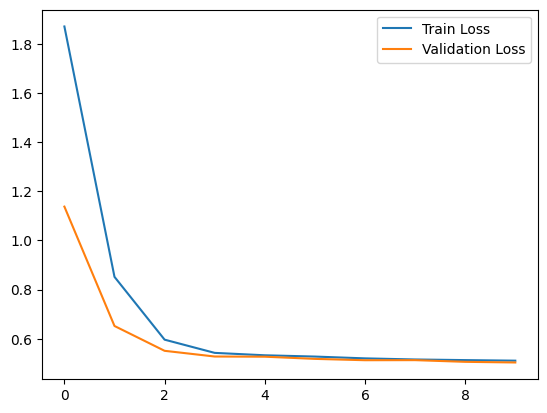

In [63]:
import matplotlib.pyplot as plt

plt.plot(training_history.history['loss'], label='Train Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


### Training and Validation Loss Analysis

The graph illustrates the training and validation loss over 10 epochs during the model's retraining process. Here's a breakdown of key observations:

#### Key Insights:

1. **Rapid Loss Reduction**:
   - The training loss decreases sharply in the initial epochs, indicating that the model quickly learns the patterns in the training data.
   - Validation loss follows a similar trend, showcasing a good generalization on unseen data.

2. **Stability After Epoch 5**:
   - Both the training and validation loss plateau after approximately 5 epochs, suggesting that the model has reached a point of convergence.

3. **No Overfitting Observed**:
   - The gap between the training and validation loss remains minimal, which indicates that the model performs consistently across both datasets without overfitting.

#### Implications:
This training behavior highlights the effectiveness of the model architecture and the augmentation techniques applied during retraining. The stable convergence of both losses showcases the model's ability to generalize well, making it robust for providing recommendations to both existing and new users.

This evaluation reinforces the model's reliability and adaptability after incorporating additional labeled data during the active learning process.


### Conclusion

Through this project, we explored the development and refinement of a recommendation system using Neural Collaborative Filtering (NCF) enhanced with active learning techniques. Here's a summary of our key steps and observations:

#### Key Steps Undertaken:
1. **Data Preparation**:
   - A robust data processing pipeline was built to prepare user-item interaction matrices and additional content-based features from the dataset.
   - Negative sampling and data augmentation strategies were implemented to balance the dataset.

2. **Model Architecture**:
   - An advanced NCF model was designed, incorporating user-item embeddings and advanced interaction techniques like absolute differences and concatenation.
   - Dropout, batch normalization, and L2 regularization were applied to improve model generalization.

3. **Active Learning**:
   - We used uncertainty-based active learning to identify the most ambiguous predictions for manual labeling.
   - The newly labeled data was seamlessly integrated into the training pipeline to enhance model performance iteratively.

4. **Hybrid Recommendations**:
   - A hybrid recommendation approach combining predicted scores with item popularity was implemented to balance personalization with general popularity trends.

5. **Evaluation and Retraining**:
   - The model's performance was evaluated using metrics such as accuracy, AUC, precision, and recall.
   - Visualizations of loss and accuracy over epochs confirmed stable convergence and effective learning during retraining.

#### Key Insights:
- **Model Adaptability**: The active learning approach demonstrated the model's ability to quickly adapt to new data by prioritizing uncertain samples for labeling and retraining.
- **Performance Stability**: The consistent alignment of training and validation losses across epochs reflected a well-generalized model.
- **Improved Recommendations**: The integration of hybrid scoring allowed the system to generate recommendations that balance personalization with broader trends, catering to both new and existing users.

#### Final Remarks:
This project highlights the power of combining NCF and active learning to build a dynamic and responsive recommendation system. By iteratively enhancing the training process and leveraging hybrid approaches, we created a system that is both accurate and flexible, capable of delivering meaningful recommendations to users while adapting to new interactions. This methodology can be further extended to other domains where personalization and adaptability are critical.
